<div style="text-align: right"> - last edit : 2019. 05. 20 </div>

## SSL (방위각 추정)
- Based on MRCG
- Using 2DCNN plus 1DCNN

### Inputs : 
- Input : MRCG of Left and Right Channels  

In [1]:
# Common imports
import numpy as np
import pandas as pd
import os, sys, glob  
import tensorflow as tf

import librosa
import librosa.display

# To plot pretty figures
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def reset_graph(seed=42):
    tf.reset_default_graph() 
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def reset_keras_session(seed=42):
    tf.keras.backend.clear_session()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# import warnings
# warnings.filterwarnings("ignore")   # To rid of warnings 

os_sep = os.sep 

if sys.platform == 'win32':   # if windows 
    home = os.path.join('D:', os.sep, 'hblee')   # d:\hblee
    data_repo = os.path.join('D:', os.sep, 'Data_Repo_Win')   # d:\Data_Repo_Win
elif sys.platform == "linux" or sys.platform == "linux2" :    # if linux 
    home = os.path.expanduser("~")   # home = os.getenv("HOME")
    data_repo = os.path.join(home, 'Data_Repo')
    
sys.path.append(os.path.join(home, 'Google_Sync', 'Dev_Exercise', 'utils'))
# from tf_utils import *
    
import MRCG as mrcg
import scipy.io.wavfile
import wave
import time

from tensorflow import keras 
keras.__version__, tf.VERSION

('2.1.6-tf', '1.12.0')

In [2]:
def show_model_graph(model, to_file="./temp_model_plot.png", show_shapes=True):
    from IPython.display import Image
    from tensorflow.keras.utils import plot_model
    
    plot_model(model, to_file, show_shapes=show_shapes)
    return Image(to_file) 

In [3]:
sample_vad_seg_repo = os.path.join('..', 'Data', 'binary_segment')   # 적절하게 변경 필요 
samples_vad_seg = glob.glob(os.path.join(sample_vad_seg_repo, '**', '*[npy|npz]'), recursive=True)

samples_vad_seg = sorted(samples_vad_seg)   
print(len(samples_vad_seg))
# list(enumerate(samples_vad_seg))

sample_data_repo = os.path.join('..', 'Data', 'sample_data', 't3_audio')
samples = glob.glob(os.path.join(sample_data_repo, '**', '*wav'), recursive=True)
samples = sorted(samples)   # sort the samples
print(len(samples))

50
50


In [4]:
# Check if the "samples_vad_seg" and "samples" are aligned 
list(zip(samples_vad_seg, samples))[::7]

[('..\\Data\\binary_segment\\01.npy',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0001.wav'),
 ('..\\Data\\binary_segment\\08.npy',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0008.wav'),
 ('..\\Data\\binary_segment\\15.npy',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0015.wav'),
 ('..\\Data\\binary_segment\\22.npy',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0022.wav'),
 ('..\\Data\\binary_segment\\29.npy',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0029.wav'),
 ('..\\Data\\binary_segment\\36.npy',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0036.wav'),
 ('..\\Data\\binary_segment\\sample_data_43.npz',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0043.wav'),
 ('..\\Data\\binary_segment\\sample_data_50.npz',
  '..\\Data\\sample_data\\t3_audio\\t3_audio_0050.wav')]

### Note ; `samples_vad_seg` 와 `samples` 가 align 되어야 함

처음 12개 샘플 (0도)을 [0|1]* 로 레이블링한 것은 왼쪽 것을 사용해야 함.  오른쪽 채널을 모두 0 으로 하였기에.

In [5]:
# testing for a sample in 0-degree set
audio = np.load(samples_vad_seg[0])
print(audio.shape)

print(pd.Series(audio[0]).value_counts())
print()
print(pd.Series(audio[1]).value_counts())

(2, 126155)
1.0    92610
0.0    33545
dtype: int64

0.0    126155
dtype: int64


In [6]:
def mrcg_generation(file_path, sr=44100):
    """
    file_path : path to the audio file 
    """
    X, sample_rate = librosa.load(file_path, sr=sr, mono=False)
    mrcg_L = mrcg.mrcg_extract(X[0], sample_rate)
    mrcg_R = mrcg.mrcg_extract(X[1], sample_rate)
    
    return mrcg_L, mrcg_R

def generate_instances(array_2d, seq_len, hop, label):
    """
    array_2d : spectrogram or mrcg like (contrains frames generated from the audio file)
    seq_len : number of frames in an instance
    hop : jump between the instances 
    label : 0 and 1's. Has same length as original numpy vector from the audio 
    """

    row_size, col_size = array_2d.shape[0], array_2d.shape[1]
    ratio = len(label)/col_size    # audio_samples per frame 
    stack_array = []    # 4D tensor that will hold the instances
    label_array = []

    j=0
    while j <= (col_size - (seq_len+1)): 
        context_frame = array_2d[:, j:(j+seq_len)]
        seg_label = round(label[int(j*ratio):int((j+seq_len)*ratio)].mean())  
        
        stack_array.append(context_frame[:,:,np.newaxis]) # build context_frame to 3d tensor & append 
        label_array.append(seg_label)
            
        j = j+hop
        
    return np.stack(stack_array, axis=0), label_array   # Return 4D tensor 

In [ ]:
%%time

# samples_vad_seg : list with paths to a file that segments audio file/sample to noise and signal 
# samples : list with paths to original audio files

mrcg_L_tensor = []   # holds 1sec mcrg instances generated from the left, grouped with audio samples 
mrcg_R_tensor = []   # holds 1sec mcrg instances generated from the right, grouped with audio samples 
label_list = [] 

for i in range(0, 50):   # 'samples_vad_seg' and 'samples' are aligned
    print("%d, "%(i), end='')
    sn_label = np.load(samples_vad_seg[i])
    if('npy' in samples_vad_seg[i].split('/')[-1]):
        label = sn_label[0]        # use the left channel label.  this take care of 0 degree problem
    else:                                   # npz file
        label = sn_label["label"]   
    # label : holds 0/1 train that segments the audio sample to signal and noise
    
    # generate instance tensors with 1sec duration (100 frames), at every 0.1 sec apart (10 hops)
    mrcg_L, mrcg_R = mrcg_generation(samples[i])
    mrcg_L_stack, _ = generate_instances(mrcg_L, 100, 10, label)
    mrcg_R_stack, label_array = generate_instances(mrcg_R, 100, 10, label)
    
    mrcg_L_tensor.append(mrcg_L_stack)
    mrcg_R_tensor.append(mrcg_R_stack)
    label_list.append(label_array)

Now we have left, right, and label 1sec instances of mrcg represenations grouped in audio samples. 
    
#### Saving and restoring :

In [8]:
# np.savez('mcrg_representation.npz', mrcg_L_tensor=mrcg_L_tensor, mrcg_R_tensor=mrcg_R_tensor, 
#         label_list=label_list)

mrcg_L_tensor = np.load('mcrg_representation.npz')['mrcg_L_tensor']
mrcg_R_tensor = np.load('mcrg_representation.npz')['mrcg_R_tensor']
label_list = np.load('mcrg_representation.npz')['label_list']

In [9]:
print(len(mrcg_L_tensor), len(mrcg_R_tensor), len(label_list))

'''
checking what 18'th audio sample's mrcg representation looks like
- the audio sample generated 14 instances to each left and right channels
- Out of 14 instances, 3 are labeled Noise, and 11 as Signal(Voice)
'''
sample_index = 17
mrcg_L_tensor[sample_index].shape, mrcg_R_tensor[sample_index].shape, label_list[sample_index]

50 50 50


((14, 768, 100, 1),
 (14, 768, 100, 1),
 [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0])

In [10]:
# Now stack the left and right instaces along the last dimension so that 'no_channels' becomes 2
total_instances_tensor = []

for i in range(0, 50):
    concat_tensor = np.concatenate([mrcg_L_tensor[i], mrcg_R_tensor[i]], axis=-1)
    total_instances_tensor.append(concat_tensor)

len(total_instances_tensor), total_instances_tensor[sample_index].shape

(50, (14, 768, 100, 2))

`total_instances_tensor` has 50 elements, where each element holds instances produced from the corresponding audio

In [11]:
total_label = []

for i in range(0, 50):
    array_label = np.array(label_list[i])   # Convert to ndarrays
    total_label.append(array_label)

In [12]:
# Test: the ratio of instances with 0 or 1 label.  74% are labeled 1 (voice)
ave=[]
for arr in total_label:
    ave.append(np.mean(arr))

np.mean(ave)

0.7424703021349098

In [13]:
# check
for i in range(0, 50, 5):
    print(total_instances_tensor[i].shape, total_label[i].shape)

(19, 768, 100, 2) (19,)
(15, 768, 100, 2) (15,)
(16, 768, 100, 2) (16,)
(30, 768, 100, 2) (30,)
(6, 768, 100, 2) (6,)
(10, 768, 100, 2) (10,)
(23, 768, 100, 2) (23,)
(14, 768, 100, 2) (14,)
(47, 768, 100, 2) (47,)
(19, 768, 100, 2) (19,)


각각의 음성 샘플에 대해 알맞게 데이터가 형성

In [14]:
# the total number of instances generated:
val = 0
for i in range(0, 50):
    val = val + total_instances_tensor[i].shape[0]
    
val

1023

#### noise와 voice 방향에 따라 labeling
- noise : 0                 
- 0도 : 1                
- 60도 : 2                
- 120도 : 3             
- 180도 : 4                  

In [15]:
for i in range(12,25):
    for j in range(0, len(total_label[i])):
        if(total_label[i][j] == 1):
            total_label[i][j] = 2       # 60 degree to label 2
            
for i in range(25,38):
    for j in range(0, len(total_label[i])):
        if(total_label[i][j] == 1):
            total_label[i][j] = 3   # 120 degree to label 3
            
for i in range(38,50):
    for j in range(0, len(total_label[i])):
        if(total_label[i][j] == 1):
            total_label[i][j] = 4
            
total_label[::5]   # Checking ...

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0.]),
 array([2., 2., 2., 2., 2., 2.]),
 array([3., 3., 3., 3., 3., 3., 3., 3., 3., 0.], dtype=float32),
 array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3.], dtype=float32),
 array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 0., 0.]),
 array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 0.])]

In [16]:
# Check again ...
for i in range(0, 50, 10):
    print(total_instances_tensor[i].shape, total_label[i].shape)

(19, 768, 100, 2) (19,)
(16, 768, 100, 2) (16,)
(6, 768, 100, 2) (6,)
(23, 768, 100, 2) (23,)
(47, 768, 100, 2) (47,)


We have 1023 instances. And we have labeled them into 5 classes.  Let's see how those labels are distributed.

In [17]:
instances_labels = np.array([])
for audio_clip in total_label:
    instances_labels = np.hstack([instances_labels, audio_clip])
   
pd.Series(instances_labels).value_counts().sort_index()   

0.0    276
1.0    155
2.0    165
3.0    234
4.0    193
dtype: int64

- Class-0 Noise instance has the greatest proportion

### Now we have `total_instances_tensor & total_label`
- `total_instances_tensor` : List. 50 elements.  Each element has instances of the audio 
- `total_label` ; List. 50 elements 

## Construct `train and validation set` split.
- Out of instances generated from the 50 audio samples, we will take instances from 40 audio files for training set, and the remaining to the validation set.  Try to mix them evenly.
- Note that `total_label` indices has : 0~11(Class-1), 12~24(Class-2), 23~37(Class-3), 38~49(Class-4) and Class-0 is assigned to the noise  

In [18]:
# Convert to ndarrays 
total_instances_tensors = np.array(total_instances_tensor)
total_label_tensors = np.array(total_label)

# randomly choose indices to be split to training and validation set
np.random.seed(19)
idx = np.random.permutation(50)
idx, idx[-10:]

(array([24, 23, 35, 30, 26, 20, 18, 43, 37, 48, 13, 36, 14,  1, 12,  6, 49,
         0, 45, 27,  8,  3, 28, 42, 25, 17, 38, 39, 21,  4, 32, 11,  9,  7,
        16, 15, 41, 44, 33,  5, 47, 22,  2, 31, 10, 19, 40, 34, 46, 29]),
 array([47, 22,  2, 31, 10, 19, 40, 34, 46, 29]))

validation set                    
- 0도 - 2개               
- 60도 - 2개                  
- 120도 - 3개               
- 180도 - 3개              

In [19]:
X = total_instances_tensors[[idx]]   # Shuffle the data using fancy indexing
y = total_label_tensors[[idx]]

# Test 
for i in range(0, 50, 10):
    print(X[i].shape, y[i].shape)

(18, 768, 100, 2) (18,)
(24, 768, 100, 2) (24,)
(9, 768, 100, 2) (9,)
(9, 768, 100, 2) (9,)
(15, 768, 100, 2) (15,)


C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [20]:
# Split to Train and Val set 
X_train = np.concatenate(X[:40], axis=0)
y_train = np.concatenate(y[:40], axis=0)

X_val = np.concatenate(X[40: ], axis=0)
y_val = np.concatenate(y[40: ], axis=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

# Change numeric to categoricals
y_train = keras.utils.to_categorical(y_train, 5)
y_val = keras.utils.to_categorical(y_val, 5)

(781, 768, 100, 2) (781,)
(242, 768, 100, 2) (242,)


## 모델1. 2D CNN + Bidirectional GRU

In [21]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dropout
from tensorflow.keras import layers, models

In [22]:
if 'model' in locals():
    del model

input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])) # 768x100x2

conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_spectrogram)
conv_1_pool = MaxPooling2D((3, 2))(conv_1)

conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_1_pool)
conv_2_pool = MaxPooling2D((3, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2_pool)
conv_3_pool = MaxPooling2D((3, 2))(conv_3)

conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3_pool)
conv_4_pool = MaxPooling2D((3, 2))(conv_4)

shape_conv_4_pool = conv_4_pool.get_shape().as_list()    # (None, height, width, channel)
conv_5 = Conv2D(512, (shape_conv_4_pool[1], 1), padding='valid', activation='relu')(conv_4_pool)
shape_conv_5 = conv_5.get_shape().as_list()

reshaped = layers.Reshape((shape_conv_5[2], shape_conv_5[3]))(conv_5)   # reshape to (timesteps, features) explicitly 
bgru = Bidirectional(layers.GRU(units=256))(reshaped)

fc1 = layers.Dense(32, activation='relu')(bgru)
fc1_drop = Dropout(0.5)(fc1)

dense_out = layers.Dense(5, activation='softmax')(fc1_drop)

model = models.Model(inputs=input_spectrogram, outputs=dense_out)
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768, 100, 2)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 768, 100, 16)      304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 50, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 50, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 12, 64)        0         
__________

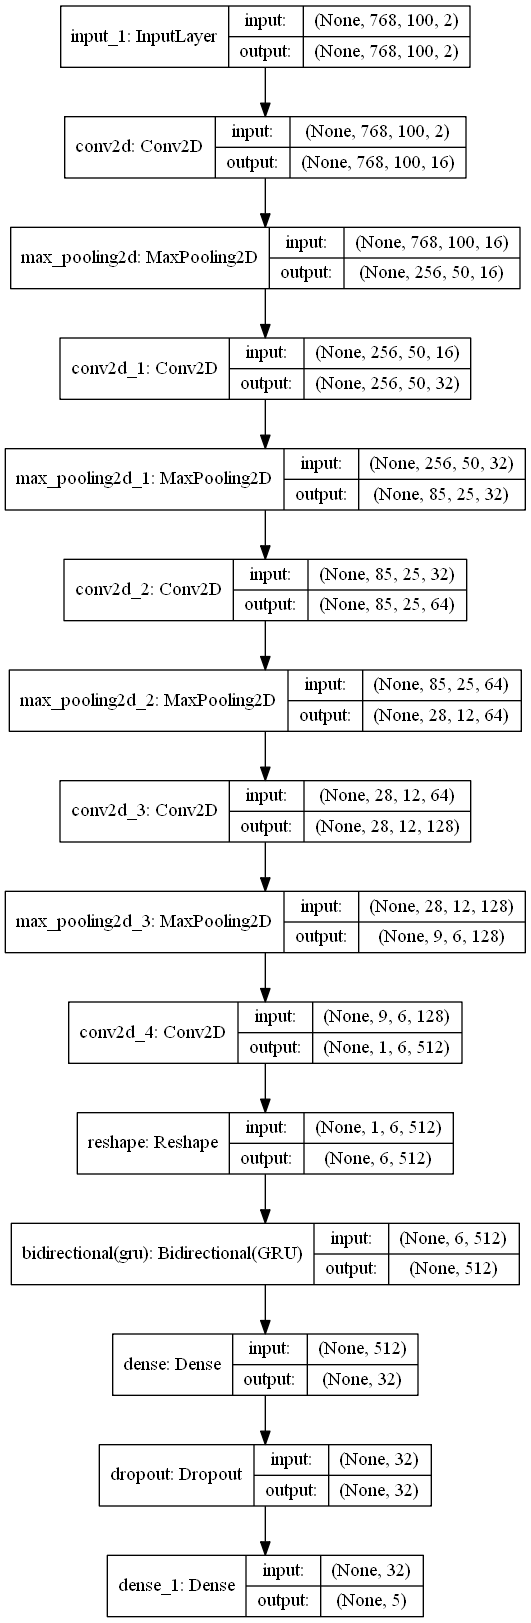

In [23]:
show_model_graph(model)

In [24]:
model.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['acc'])

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=30)]

history = model.fit(X_train, y_train,
                    epochs=150, batch_size=128, 
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    shuffle=False)

Train on 781 samples, validate on 242 samples
Epoch 1/150
781/781 [==============================] - 8s 10ms/step - loss: 2.4442 - acc: 0.2458 - val_loss: 1.6270 - val_acc: 0.2314
Epoch 2/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6237 - acc: 0.1729 - val_loss: 1.6109 - val_acc: 0.2314
Epoch 3/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6110 - acc: 0.1754 - val_loss: 1.6097 - val_acc: 0.1694
Epoch 4/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6120 - acc: 0.2330 - val_loss: 1.6103 - val_acc: 0.2397
Epoch 5/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6064 - acc: 0.2369 - val_loss: 1.6114 - val_acc: 0.2397
Epoch 6/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6068 - acc: 0.2791 - val_loss: 1.6131 - val_acc: 0.2397
Epoch 7/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6084 - acc: 0.2791 - val_loss: 1.6105 - val_acc: 0.2397
Epoch 8/150
781/781 [=

Epoch 62/150
781/781 [==============================] - 2s 3ms/step - loss: 0.1274 - acc: 0.9437 - val_loss: 1.3082 - val_acc: 0.8017
Epoch 63/150
781/781 [==============================] - 2s 3ms/step - loss: 0.1455 - acc: 0.9309 - val_loss: 1.3312 - val_acc: 0.8017
Epoch 64/150
781/781 [==============================] - 2s 3ms/step - loss: 0.1125 - acc: 0.9488 - val_loss: 1.3211 - val_acc: 0.8058
Epoch 65/150
781/781 [==============================] - 2s 3ms/step - loss: 0.1213 - acc: 0.9462 - val_loss: 1.5457 - val_acc: 0.7975
Epoch 66/150
781/781 [==============================] - 2s 3ms/step - loss: 0.1022 - acc: 0.9603 - val_loss: 1.1388 - val_acc: 0.8223
Epoch 67/150
781/781 [==============================] - 2s 3ms/step - loss: 0.1026 - acc: 0.9552 - val_loss: 1.7957 - val_acc: 0.7851
Epoch 68/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0799 - acc: 0.9667 - val_loss: 1.7068 - val_acc: 0.7893
Epoch 69/150
781/781 [==============================] - 2s 3ms

Epoch 123/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0667 - acc: 0.9770 - val_loss: 2.1081 - val_acc: 0.7975
Epoch 124/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0840 - acc: 0.9706 - val_loss: 2.1109 - val_acc: 0.7975
Epoch 125/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0582 - acc: 0.9808 - val_loss: 2.1115 - val_acc: 0.7975


In [25]:
import sklearn.metrics 
# from sklearn.metrics import confusion_matrix, classification_report

y_val_pred = model.predict(X_val)
cm = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(y_val_pred, axis=1))
acc = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(y_val_pred, axis=1))
print("Accuracy : ", acc)
model.save('SSL_MRCG_2DConv_RNN.h5')    
cm

Accuracy :  0.7975206611570248


array([[51,  2,  0,  0,  5],
       [ 4, 13,  0,  0,  0],
       [21,  0, 25,  0,  0],
       [13,  0,  0, 52,  0],
       [ 4,  0,  0,  0, 52]], dtype=int64)

# 모델2. 2D CNN + 1D CNN
- 처음에는 2D CNN을 써서 `주파수-시간` 2차원 도메인.  2D CNN 뒤에 1D CNN을 stack.
- 앞서 만든 데이터셋 활용 : `X_train, y_train, X_val, y_val` 

In [26]:
for data_set in [[X_train, 'X_train'], [y_train, 'y_train'], 
                 [X_val,'X_val'], [y_val, 'y_val']]:
    print(data_set[1], ": ", data_set[0].shape)

X_train :  (781, 768, 100, 2)
y_train :  (781, 5)
X_val :  (242, 768, 100, 2)
y_val :  (242, 5)


### Version-1

In [27]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, Flatten, Dropout

if 'model' in locals():
    del model
    
input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

conv_1 = Conv2D(16, (3, 3), activation='relu', padding='valid')(input_spectrogram)
conv_1_pool = MaxPooling2D((3, 2))(conv_1)

conv_2 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv_1_pool)
conv_2_pool = MaxPooling2D((3, 2))(conv_2)

conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_2_pool)
conv_3_pool = MaxPooling2D((4, 2))(conv_3)

conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3_pool)
conv_4_pool = MaxPooling2D((4, 2))(conv_4)
shape_conv_4_pool = conv_4_pool.get_shape().as_list()    # (None, height, width, channel)

conv_5 = Conv2D(512, (shape_conv_4_pool[1], 1), padding='valid', activation='relu')(conv_4_pool)
shape_conv_5 = conv_5.get_shape().as_list()

reshaped = layers.Reshape((shape_conv_5[2], shape_conv_5[3]))(conv_5)   # reshape to (timesteps, features) explicitly 

conv_6 = Conv1D(512, kernel_size=3, activation='relu')(reshaped)
flatten = layers.Flatten()(conv_6)
flatten_drop = Dropout(0.3)(flatten)

fc1 = layers.Dense(64, activation='relu')(flatten_drop)
fc1_drop = Dropout(0.3)(fc1)

dense_out = layers.Dense(5, activation='softmax')(fc1_drop)

model = models.Model(inputs=input_spectrogram, outputs=dense_out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 768, 100, 2)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 766, 98, 16)       304       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 255, 49, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 253, 47, 64)       9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 84, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 11, 128)       0         
__________

In [28]:
model.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['acc'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss', patience=20),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=10)]

history = model.fit(X_train, y_train,
                    epochs=150, batch_size=64, 
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    shuffle=False)

Train on 781 samples, validate on 242 samples
Epoch 1/150
781/781 [==============================] - 5s 6ms/step - loss: 1.8627 - acc: 0.1908 - val_loss: 1.6192 - val_acc: 0.0702
Epoch 2/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6156 - acc: 0.2074 - val_loss: 1.6067 - val_acc: 0.2397
Epoch 3/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6023 - acc: 0.2817 - val_loss: 1.5888 - val_acc: 0.2603
Epoch 4/150
781/781 [==============================] - 2s 3ms/step - loss: 1.5781 - acc: 0.2945 - val_loss: 1.4863 - val_acc: 0.4008
Epoch 5/150
781/781 [==============================] - 2s 3ms/step - loss: 1.5412 - acc: 0.3124 - val_loss: 1.4713 - val_acc: 0.4050
Epoch 6/150
781/781 [==============================] - 2s 3ms/step - loss: 1.5222 - acc: 0.2919 - val_loss: 1.5012 - val_acc: 0.3512
Epoch 7/150
781/781 [==============================] - 2s 3ms/step - loss: 1.5096 - acc: 0.3316 - val_loss: 1.5992 - val_acc: 0.2562
Epoch 8/150
781/781 [==

Epoch 62/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0188 - acc: 0.9962 - val_loss: 1.2233 - val_acc: 0.7810
Epoch 63/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0290 - acc: 0.9910 - val_loss: 1.2235 - val_acc: 0.7810
Epoch 64/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0250 - acc: 0.9936 - val_loss: 1.2234 - val_acc: 0.7810
Epoch 65/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0213 - acc: 0.9962 - val_loss: 1.2236 - val_acc: 0.7810
Epoch 66/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0232 - acc: 0.9949 - val_loss: 1.2239 - val_acc: 0.7810
Epoch 67/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0152 - acc: 0.9987 - val_loss: 1.2241 - val_acc: 0.7810
Epoch 68/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0222 - acc: 0.9949 - val_loss: 1.2244 - val_acc: 0.7810
Epoch 69/150
781/781 [==============================] - 2s 3ms

In [29]:
import sklearn.metrics 
# from sklearn.metrics import confusion_matrix, classification_report

y_val_pred = model.predict(X_val)
cm = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(y_val_pred, axis=1))
acc = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(y_val_pred, axis=1))
print("Accuracy : ", acc)
model.save('SSL_MRCG_2DConv_1DConv.h5')    
cm

Accuracy :  0.78099173553719


array([[48,  2,  0,  4,  4],
       [ 4, 13,  0,  0,  0],
       [23,  0, 22,  1,  0],
       [14,  0,  0, 51,  0],
       [ 0,  0,  0,  1, 55]], dtype=int64)

### Version-2

In [30]:
reset_keras_session(100)

if 'model' in locals():
    del model
    
input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

conv_1 = Conv2D(16, (3, 3), activation='relu')(input_spectrogram)
max_pool_1 = MaxPooling2D((2, 2))(conv_1)

conv_2 = Conv2D(32, (3, 3), activation='relu')(max_pool_1)
max_pool_2 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), strides=(2,1), activation='relu')(max_pool_2)
conv_3_1 = Conv2D(64, (3, 2), strides=(2,1), activation='relu')(conv_3)
max_pool_3 = MaxPooling2D((3, 2), name='max_pool_3')(conv_3_1)

shape_max_pool_3 = max_pool_3.get_shape().as_list()    # (None, height, width, channel)
print("shape_max_pool_3 : ", shape_max_pool_3)
# reshaped = layers.Reshape((-1, shape_list[1]*shape_list[3]))(max_pool_3)

conv_4 = Conv2D(1024, (shape_max_pool_3[1], 1), padding='valid', activation='relu')(max_pool_3)
shape_conv_4 = conv_4.get_shape().as_list()
print("shape_conv_4 : ", shape_conv_4)

reshaped = layers.Reshape((shape_conv_4[2], shape_conv_4[3]))(conv_4) # reshape to (timesteps, features) explicitly 

conv_5 = Conv1D(512, kernel_size=3, activation='relu')(reshaped)

flatten = layers.Flatten()(conv_5)
# flatten_drop = Dropout(0.3)(flatten)

fc1 = layers.Dense(32, activation='relu')(flatten)
fc1_drop = Dropout(0.1)(fc1)
dense_out = layers.Dense(5, activation='softmax')(fc1_drop)

model = models.Model(inputs=input_spectrogram, outputs=dense_out)
model.summary()

shape_max_pool_3 :  [None, 15, 10, 64]
shape_conv_4 :  [None, 1, 10, 1024]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768, 100, 2)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 766, 98, 16)       304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 383, 49, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 381, 47, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 190, 23, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 21, 64)        18496     
_________________________________________________________________
c

In [31]:
model.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['acc'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss', patience=20),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=10)]

history = model.fit(X_train, y_train,
                    epochs=150, batch_size=64, 
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    shuffle=False)

Train on 781 samples, validate on 242 samples
Epoch 1/150
781/781 [==============================] - 4s 5ms/step - loss: 1.6582 - acc: 0.2023 - val_loss: 1.6416 - val_acc: 0.2397
Epoch 2/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6149 - acc: 0.2561 - val_loss: 1.6208 - val_acc: 0.2397
Epoch 3/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6034 - acc: 0.2804 - val_loss: 1.6599 - val_acc: 0.2397
Epoch 4/150
781/781 [==============================] - 2s 3ms/step - loss: 1.6028 - acc: 0.2702 - val_loss: 1.6192 - val_acc: 0.2397
Epoch 5/150
781/781 [==============================] - 2s 3ms/step - loss: 1.5803 - acc: 0.2778 - val_loss: 1.6122 - val_acc: 0.2397
Epoch 6/150
781/781 [==============================] - 2s 3ms/step - loss: 1.5447 - acc: 0.2907 - val_loss: 1.5811 - val_acc: 0.2397
Epoch 7/150
781/781 [==============================] - 2s 3ms/step - loss: 1.4996 - acc: 0.2996 - val_loss: 1.5370 - val_acc: 0.2769
Epoch 8/150
781/781 [==

Epoch 62/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0535 - acc: 0.9821 - val_loss: 1.4253 - val_acc: 0.7645
Epoch 63/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0699 - acc: 0.9718 - val_loss: 1.4210 - val_acc: 0.7645
Epoch 64/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0530 - acc: 0.9770 - val_loss: 1.4187 - val_acc: 0.7645
Epoch 65/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0640 - acc: 0.9693 - val_loss: 1.4172 - val_acc: 0.7645
Epoch 66/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0540 - acc: 0.9795 - val_loss: 1.4172 - val_acc: 0.7645
Epoch 67/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0737 - acc: 0.9693 - val_loss: 1.4170 - val_acc: 0.7645
Epoch 68/150
781/781 [==============================] - 2s 3ms/step - loss: 0.0657 - acc: 0.9731 - val_loss: 1.4168 - val_acc: 0.7645
Epoch 69/150
781/781 [==============================] - 2s 3ms

In [76]:
import sklearn.metrics 
# from sklearn.metrics import confusion_matrix, classification_report

y_val_pred = model.predict(X_val)
cm = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(y_val_pred, axis=1))
acc = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(y_val_pred, axis=1))
print("Accuracy : ", acc)
model.save('SSL_MRCG_2DConv_1DConv.h5')    
cm

Accuracy :  0.8057851239669421


array([[50,  3,  0,  1,  4],
       [ 3, 14,  0,  0,  0],
       [17,  0, 26,  3,  0],
       [14,  0,  0, 51,  0],
       [ 2,  0,  0,  0, 54]], dtype=int64)